In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

In [146]:
#import data
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
df = pd.read_csv(data)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [148]:
#First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[((df["ocean_proximity"]=="<1H OCEAN") | (df["ocean_proximity"]=="INLAND"))]
display(df)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [149]:
#Fill missing values with zeros.
df = df.fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [150]:
#Apply the log transform to median_house_value.
df.median_house_value = np.log(df.median_house_value)

In [151]:
#Do train/validation/test split with 60%/20%/20% distribution.
#Use the train_test_split function and set the random_state parameter to 1.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value
y_val = df_val.median_house_value
y_test = df_test.median_house_value

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [152]:
#Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
num_cols = df_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = df_train.select_dtypes(include=object).columns.tolist()

dv = DictVectorizer(sparse=True)

train_dict = df_train[num_cols+cat_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
print(list(dv.get_feature_names_out()))

val_dict = df_val[num_cols+cat_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[num_cols+cat_cols].to_dict(orient='records')
X_test = dv.transform(test_dict)

['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximity=<1H OCEAN', 'ocean_proximity=INLAND', 'population', 'total_bedrooms', 'total_rooms']


[Text(0.5, 0.75, 'x[6] <= 0.5\nsquared_error = 0.322\nsamples = 9411\nvalue = 12.011'),
 Text(0.25, 0.25, 'squared_error = 0.186\nsamples = 5487\nvalue = 12.301'),
 Text(0.75, 0.25, 'squared_error = 0.23\nsamples = 3924\nvalue = 11.607')]

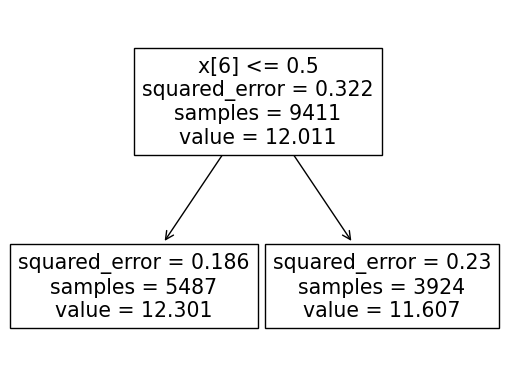

In [153]:
###Question 1
#Let's train a decision tree regressor to predict the median_house_value variable.

#Train a model with max_depth=1.
#Which feature is used for splitting the data? --> ocean_proximity
#ocean_proximity
#total_rooms
#latitude
#population
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train,y_train)
tree.plot_tree(dt)

In [154]:
###Question 2
#Train a random forest model with these parameters:

#n_estimators=10
#random_state=1
#n_jobs=-1 (optional - to make training faster)
#What's the RMSE of this model on validation? -> 0.245

#0.045
#0.245
#0.545
#0.845

rfc = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
mse = mean_squared_error(y_pred, y_val)
rmse = np.sqrt(mse)
print("RMSE", rmse)

RMSE 0.2454364295869227


In [155]:
#Question 3
#Now let's experiment with the n_estimators parameter

#Try different values of this parameter from 10 to 200 with step 10.
#Set random_state to 1.
#Evaluate the model on the validation dataset.
#After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer. --> 160

#10
#25
#50
#160

rmse_arr = []

for n in range(10, 201, 10):
    rfc = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_val)
    mse = mean_squared_error(y_pred, y_val)
    rmse = np.sqrt(mse)
    rmse_arr.append((rmse, n))

,rmse,n_estimators
0,0.245436,10
1,0.238642,20
2,0.237327,30
3,0.235834,40
4,0.235656,50
5,0.235282,60
6,0.234882,70
7,0.234880,80
8,0.234625,90
9,0.234516,100


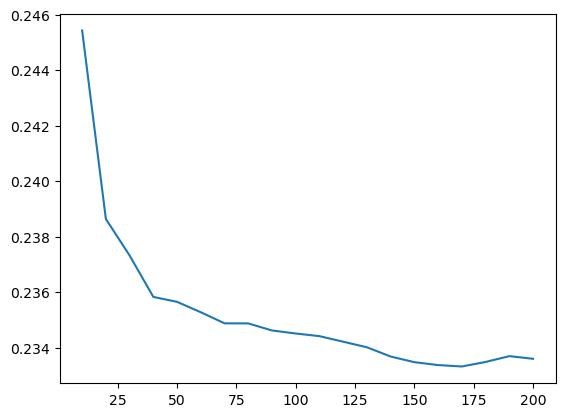

In [156]:
df_rmse = pd.DataFrame(rmse_arr, columns=("rmse", "n_estimators"))
display(df_rmse)
plt.plot(df_rmse.n_estimators, df_rmse.rmse)

In [157]:
###Question 4
#Let's select the best max_depth:

#Try different values of max_depth: [10, 15, 20, 25]
#For each of these values,
#try different values of n_estimators from 10 till 200 (with step 10)
#calculate the mean RMSE
#Fix the random seed: random_state=1
#What's the best max_depth, using the mean RMSE? -> 20

#10
#15
#20
#25

rmse_arr = []
rmse_arr_mean = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rfc = RandomForestRegressor(n_estimators=n, max_depth=d ,random_state=1, n_jobs=-1)
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_val)
        mse = mean_squared_error(y_pred, y_val)
        rmse = np.sqrt(mse)
        rmse_arr.append(rmse)
    rmse_arr_mean.append((d, np.mean(rmse_arr)))
    rmse_arr = []

In [158]:
df_rmse = pd.DataFrame(rmse_arr_mean, columns=["max_depth", "rmse_mean"])
display(df_rmse)

,max_depth,rmse_mean
0,10,0.245242
1,15,0.235986
2,20,0.234789
3,25,0.235041


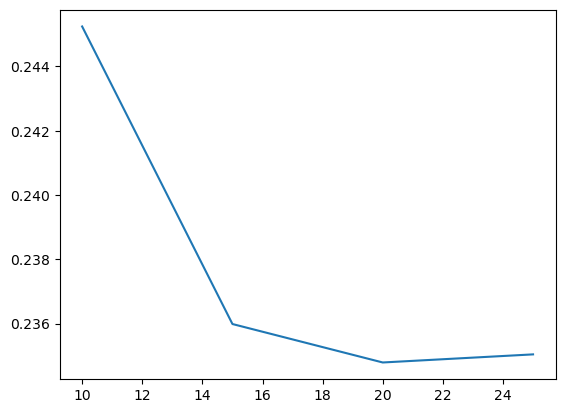

In [159]:
plt.plot(df_rmse.max_depth, df_rmse.rmse_mean)

In [160]:
###Question 5
#We can extract feature importance information from tree-based models.
#At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.
#In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.
#For this homework question, we'll find the most important feature:
#Train the model with these parameters:
#n_estimators=10,
#max_depth=20,
#random_state=1,
#n_jobs=-1 (optional)
#Get the feature importance information from this model
#What's the most important feature (among these 4)? --> median_income

#total_rooms -> 0.021
#median_income -> 0.335
#total_bedrooms -> 0.015
#longitude -> 0.087

rfm = RandomForestRegressor(n_estimators=10,max_depth=20, random_state=1, n_jobs=-1)
rfm.fit(X_train, y_train)
list(np.round(rfm.feature_importances_, 3))

[0.015, 0.03, 0.101, 0.087, 0.335, 0.0, 0.366, 0.028, 0.015, 0.021]

In [161]:
print(list(dv.get_feature_names_out()))

['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximity=<1H OCEAN', 'ocean_proximity=INLAND', 'population', 'total_bedrooms', 'total_rooms']


In [162]:
df_feature_importance = pd.DataFrame(list(np.round(rfm.feature_importances_, 3)), list(dv.get_feature_names_out()))
display(df_feature_importance)

,0
households,0.015
housing_median_age,0.030
latitude,0.101
longitude,0.087
median_income,0.335
ocean_proximity=<1H OCEAN,0.000
ocean_proximity=INLAND,0.366
population,0.028
total_bedrooms,0.015
total_rooms,0.021


In [165]:
###Question 6
#Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

#Install XGBoost
#Create DMatrix for train and validation
#Create a watchlist
#Train a model with these parameters for 100 rounds:
#xgb_params = {
    #'eta': 0.3, 
    #'max_depth': 6,
    #'min_child_weight': 1,
    
    #'objective': 'reg:squarederror',
    #'nthread': 8,
    
    #'seed': 1,
    #'verbosity': 1,
#}
#Now change eta from 0.3 to 0.1.
#Which eta leads to the best RMSE score on the validation dataset? -> 0.3
#0.3
#0.1
#Both give equal value
import xgboost as xgb

In [197]:
#Create DMatrix
features = dv.get_feature_names_out()
for idx, feature in enumerate(features):   
    features[idx]=feature.replace("=<", "_").replace("=","_")
features = list(features)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [198]:
#Create watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [199]:
#Params
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [200]:
#Train a model for 100 rounds
model = xgb.train(xgb_params, dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)

[0]	train-rmse:0.44351	val-rmse:0.44250
[5]	train-rmse:0.25338	val-rmse:0.27463
[10]	train-rmse:0.21445	val-rmse:0.25179
[15]	train-rmse:0.19858	val-rmse:0.24523
[20]	train-rmse:0.18524	val-rmse:0.23978
[25]	train-rmse:0.17757	val-rmse:0.23830
[30]	train-rmse:0.16888	val-rmse:0.23571
[35]	train-rmse:0.16113	val-rmse:0.23416
[40]	train-rmse:0.15542	val-rmse:0.23319
[45]	train-rmse:0.14941	val-rmse:0.23190
[50]	train-rmse:0.14536	val-rmse:0.23225
[55]	train-rmse:0.14150	val-rmse:0.23197
[60]	train-rmse:0.13719	val-rmse:0.23139
[65]	train-rmse:0.13260	val-rmse:0.23158
[70]	train-rmse:0.12943	val-rmse:0.23068
[75]	train-rmse:0.12555	val-rmse:0.23039
[80]	train-rmse:0.12192	val-rmse:0.22886
[85]	train-rmse:0.11854	val-rmse:0.22888
[90]	train-rmse:0.11504	val-rmse:0.22877
[95]	train-rmse:0.11266	val-rmse:0.22865
[99]	train-rmse:0.11043	val-rmse:0.22873


In [201]:
#Now change eta from 0.3 to 0.1.
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
#Train a model for 100 rounds
model = xgb.train(xgb_params, dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)

[0]	train-rmse:0.52449	val-rmse:0.52045
[5]	train-rmse:0.37823	val-rmse:0.38152
[10]	train-rmse:0.30326	val-rmse:0.31427
[15]	train-rmse:0.26539	val-rmse:0.28380
[20]	train-rmse:0.24512	val-rmse:0.26882
[25]	train-rmse:0.23027	val-rmse:0.25997
[30]	train-rmse:0.21887	val-rmse:0.25267
[35]	train-rmse:0.21020	val-rmse:0.24827
[40]	train-rmse:0.20392	val-rmse:0.24539
[45]	train-rmse:0.19814	val-rmse:0.24293
[50]	train-rmse:0.19215	val-rmse:0.24020
[55]	train-rmse:0.18809	val-rmse:0.23878
[60]	train-rmse:0.18457	val-rmse:0.23791
[65]	train-rmse:0.18064	val-rmse:0.23698
[70]	train-rmse:0.17741	val-rmse:0.23622
[75]	train-rmse:0.17468	val-rmse:0.23510
[80]	train-rmse:0.17242	val-rmse:0.23454
[85]	train-rmse:0.17014	val-rmse:0.23404
[90]	train-rmse:0.16798	val-rmse:0.23332
[95]	train-rmse:0.16562	val-rmse:0.23276
[99]	train-rmse:0.16323	val-rmse:0.23209
